In [1]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import datetime as dt
import time
import mplcursors
from matplotlib import style
import math

%matplotlib inline

N = 5
test_size = 0.25

In [2]:
def get_mov_avg_std(df, col):
    """
    Get the mean and standard deviation of a data frame at a specific timestamp using values from t-1, t-2,..., t-N
    """

    mean_list = df[col].rolling(window = 5, min_periods = 1).mean()
    std_list = df[col].rolling(window = 5, min_periods = 1).std()

    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))

    df[col + '_MEAN'] = mean_list
    df[col + '_STD'] = std_list

    return df

def scale_row(row, feat_mean, feat_std):
    """
    Given a row of a data frame, scale it to having a mean value of 0 and variance of 1 using feat_mean and feat_std
    """

    feat_std = 0.001 if feat_std == 0 else feat_std

    row_scaled = (row-feat_mean)/feat_std
    
    return row_scaled

In [3]:
Twitter_Data = pd.read_csv('tweet_sentiments.csv', index_col = 0)
Twitter_Data.head()

,timestamp,text_bkp,text,vader_dict,neg,neu,pos,compound
0,2020-03-30T23:59:48,CityFALCON score gives top rated news for FREE...,cityfalcon score give top rated news for free ...,"{'neg': 0.0, 'neu': 0.718, 'pos': 0.282, 'comp...",0.000,0.718,0.282,0.6249
1,2020-03-30T23:59:32,No one thinks we’ve reached capitulation stage...,no one think we ve reached capitulation stage ...,"{'neg': 0.102, 'neu': 0.833, 'pos': 0.065, 'co...",0.102,0.833,0.065,-0.2023
2,2020-03-30T23:58:14,@jimcramer I had to turn you off today. You’re...,i had to turn you off today you re misleading ...,"{'neg': 0.069, 'neu': 0.867, 'pos': 0.064, 'co...",0.069,0.867,0.064,-0.0516
3,2020-03-30T23:58:11,Inside Day Scan Results (Stock > 10; Volume > ...,inside day scan result stock 10 volume 200 00 ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
4,2020-03-30T23:56:23,Hows $AAPL looking?,hows aapl looking,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000


In [4]:
Twitter_Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12513 entries, 0 to 12512
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   12513 non-null  object 
 1   text_bkp    12513 non-null  object 
 2   text        12513 non-null  object 
 3   vader_dict  12513 non-null  object 
 4   neg         12513 non-null  float64
 5   neu         12513 non-null  float64
 6   pos         12513 non-null  float64
 7   compound    12513 non-null  float64
dtypes: float64(4), object(4)
memory usage: 879.8+ KB


In [5]:
Twitter_Data['timestamp'] = pd.to_datetime(Twitter_Data['timestamp'])
Twitter_Data = Twitter_Data.rename(columns = {'timestamp':'Date'})
Twitter_Data.head()

,Date,text_bkp,text,vader_dict,neg,neu,pos,compound
0,2020-03-30 23:59:48,CityFALCON score gives top rated news for FREE...,cityfalcon score give top rated news for free ...,"{'neg': 0.0, 'neu': 0.718, 'pos': 0.282, 'comp...",0.000,0.718,0.282,0.6249
1,2020-03-30 23:59:32,No one thinks we’ve reached capitulation stage...,no one think we ve reached capitulation stage ...,"{'neg': 0.102, 'neu': 0.833, 'pos': 0.065, 'co...",0.102,0.833,0.065,-0.2023
2,2020-03-30 23:58:14,@jimcramer I had to turn you off today. You’re...,i had to turn you off today you re misleading ...,"{'neg': 0.069, 'neu': 0.867, 'pos': 0.064, 'co...",0.069,0.867,0.064,-0.0516
3,2020-03-30 23:58:11,Inside Day Scan Results (Stock > 10; Volume > ...,inside day scan result stock 10 volume 200 00 ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
4,2020-03-30 23:56:23,Hows $AAPL looking?,hows aapl looking,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000


In [6]:
def convert_to_year(x):
    date = x.date()
    return date

Twitter_Data['Date'] = Twitter_Data['Date'].apply(lambda x: convert_to_year(x))

In [7]:
Twitter_Data.head()

,Date,text_bkp,text,vader_dict,neg,neu,pos,compound
0,2020-03-30,CityFALCON score gives top rated news for FREE...,cityfalcon score give top rated news for free ...,"{'neg': 0.0, 'neu': 0.718, 'pos': 0.282, 'comp...",0.000,0.718,0.282,0.6249
1,2020-03-30,No one thinks we’ve reached capitulation stage...,no one think we ve reached capitulation stage ...,"{'neg': 0.102, 'neu': 0.833, 'pos': 0.065, 'co...",0.102,0.833,0.065,-0.2023
2,2020-03-30,@jimcramer I had to turn you off today. You’re...,i had to turn you off today you re misleading ...,"{'neg': 0.069, 'neu': 0.867, 'pos': 0.064, 'co...",0.069,0.867,0.064,-0.0516
3,2020-03-30,Inside Day Scan Results (Stock > 10; Volume > ...,inside day scan result stock 10 volume 200 00 ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
4,2020-03-30,Hows $AAPL looking?,hows aapl looking,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000


In [8]:
Twitter_Data['Date'] = pd.to_datetime(Twitter_Data['Date'])
Twitter_Data.head()

,Date,text_bkp,text,vader_dict,neg,neu,pos,compound
0,2020-03-30,CityFALCON score gives top rated news for FREE...,cityfalcon score give top rated news for free ...,"{'neg': 0.0, 'neu': 0.718, 'pos': 0.282, 'comp...",0.000,0.718,0.282,0.6249
1,2020-03-30,No one thinks we’ve reached capitulation stage...,no one think we ve reached capitulation stage ...,"{'neg': 0.102, 'neu': 0.833, 'pos': 0.065, 'co...",0.102,0.833,0.065,-0.2023
2,2020-03-30,@jimcramer I had to turn you off today. You’re...,i had to turn you off today you re misleading ...,"{'neg': 0.069, 'neu': 0.867, 'pos': 0.064, 'co...",0.069,0.867,0.064,-0.0516
3,2020-03-30,Inside Day Scan Results (Stock > 10; Volume > ...,inside day scan result stock 10 volume 200 00 ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
4,2020-03-30,Hows $AAPL looking?,hows aapl looking,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000


In [9]:
Twitter_Data.dtypes

Date          datetime64[ns]
text_bkp              object
text                  object
vader_dict            object
neg                  float64
neu                  float64
pos                  float64
compound             float64
dtype: object

In [10]:
Twitter_Data_Group = Twitter_Data.groupby(['Date']).mean()
Twitter_Data_Group = Twitter_Data_Group.reset_index()

In [11]:
Twitter_Data_Group.head()

,Date,neg,neu,pos,compound
0,2020-03-20,0.054766,0.892745,0.052462,0.022388
1,2020-03-21,0.039019,0.880170,0.080849,0.179609
2,2020-03-22,0.042453,0.874949,0.082588,0.133812
3,2020-03-24,0.021877,0.923792,0.054334,0.101594
4,2020-03-26,0.024091,0.936061,0.039849,0.065061


In [12]:
Twitter_Data_Group.dtypes

Date        datetime64[ns]
neg                float64
neu                float64
pos                float64
compound           float64
dtype: object

In [13]:
AAPL_Stock = pd.read_csv('AAPL_YAHOO.csv')
AAPL_Stock

,Date,High,Low,Open,Close,Volume,Adj Close
0,2020-03-20,251.830002,228.000000,247.179993,229.240005,100423300,229.240005
1,2020-03-23,228.500000,212.610001,228.080002,224.369995,84188200,224.369995
2,2020-03-24,247.690002,234.300003,236.360001,246.880005,71882800,246.880005
3,2020-03-25,258.250000,244.300003,250.750000,245.520004,75900500,245.520004
4,2020-03-26,258.679993,246.360001,246.520004,258.440002,63021800,258.440002
5,2020-03-27,255.869995,247.050003,252.750000,247.740005,51054200,247.740005
6,2020-03-30,255.520004,249.399994,250.740005,254.809998,41994100,254.809998
7,2020-03-31,262.489990,252.000000,255.600006,254.289993,49250500,254.289993
8,2020-04-01,248.720001,239.130005,246.500000,240.910004,44054600,240.910004
9,2020-04-02,245.149994,236.899994,240.339996,244.929993,41483500,244.929993


In [14]:
AAPL_Stock['Date'] = pd.to_datetime(AAPL_Stock['Date'])

In [15]:
AAPL_Stock.dtypes

Date         datetime64[ns]
High                float64
Low                 float64
Open                float64
Close               float64
Volume                int64
Adj Close           float64
dtype: object

In [16]:
AAPL_Twitter = pd.merge(AAPL_Stock, Twitter_Data_Group, how = 'left', left_on = 'Date', right_on = 'Date')

In [17]:
AAPL_Twitter.head()

,Date,High,Low,Open,Close,Volume,Adj Close,neg,neu,pos,compound
0,2020-03-20,251.830002,228.000000,247.179993,229.240005,100423300,229.240005,0.054766,0.892745,0.052462,0.022388
1,2020-03-23,228.500000,212.610001,228.080002,224.369995,84188200,224.369995,NaN,NaN,NaN,NaN
2,2020-03-24,247.690002,234.300003,236.360001,246.880005,71882800,246.880005,0.021877,0.923792,0.054334,0.101594
3,2020-03-25,258.250000,244.300003,250.750000,245.520004,75900500,245.520004,NaN,NaN,NaN,NaN
4,2020-03-26,258.679993,246.360001,246.520004,258.440002,63021800,258.440002,0.024091,0.936061,0.039849,0.065061


In [18]:
AAPL_Twitter.columns = [str(col).upper().replace(' ', '_') for col in AAPL_Twitter.columns]
AAPL_Twitter.head()

,DATE,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE,NEG,NEU,POS,COMPOUND
0,2020-03-20,251.830002,228.000000,247.179993,229.240005,100423300,229.240005,0.054766,0.892745,0.052462,0.022388
1,2020-03-23,228.500000,212.610001,228.080002,224.369995,84188200,224.369995,NaN,NaN,NaN,NaN
2,2020-03-24,247.690002,234.300003,236.360001,246.880005,71882800,246.880005,0.021877,0.923792,0.054334,0.101594
3,2020-03-25,258.250000,244.300003,250.750000,245.520004,75900500,245.520004,NaN,NaN,NaN,NaN
4,2020-03-26,258.679993,246.360001,246.520004,258.440002,63021800,258.440002,0.024091,0.936061,0.039849,0.065061


In [19]:
AAPL_Twitter = AAPL_Twitter.fillna(method = 'ffill')
AAPL_Twitter.head()

,DATE,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE,NEG,NEU,POS,COMPOUND
0,2020-03-20,251.830002,228.000000,247.179993,229.240005,100423300,229.240005,0.054766,0.892745,0.052462,0.022388
1,2020-03-23,228.500000,212.610001,228.080002,224.369995,84188200,224.369995,0.054766,0.892745,0.052462,0.022388
2,2020-03-24,247.690002,234.300003,236.360001,246.880005,71882800,246.880005,0.021877,0.923792,0.054334,0.101594
3,2020-03-25,258.250000,244.300003,250.750000,245.520004,75900500,245.520004,0.021877,0.923792,0.054334,0.101594
4,2020-03-26,258.679993,246.360001,246.520004,258.440002,63021800,258.440002,0.024091,0.936061,0.039849,0.065061


In [20]:
AAPL_Twitter['RANGE_OC'] = AAPL_Twitter['OPEN'] - AAPL_Twitter['CLOSE']
AAPL_Twitter['RANGE_HL'] = AAPL_Twitter['HIGH'] - AAPL_Twitter['LOW']
AAPL_Twitter.head()

,DATE,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE,NEG,NEU,POS,COMPOUND,RANGE_OC,RANGE_HL
0,2020-03-20,251.830002,228.000000,247.179993,229.240005,100423300,229.240005,0.054766,0.892745,0.052462,0.022388,17.939987,23.830002
1,2020-03-23,228.500000,212.610001,228.080002,224.369995,84188200,224.369995,0.054766,0.892745,0.052462,0.022388,3.710007,15.889999
2,2020-03-24,247.690002,234.300003,236.360001,246.880005,71882800,246.880005,0.021877,0.923792,0.054334,0.101594,-10.520004,13.389999
3,2020-03-25,258.250000,244.300003,250.750000,245.520004,75900500,245.520004,0.021877,0.923792,0.054334,0.101594,5.229996,13.949997
4,2020-03-26,258.679993,246.360001,246.520004,258.440002,63021800,258.440002,0.024091,0.936061,0.039849,0.065061,-11.919998,12.319992


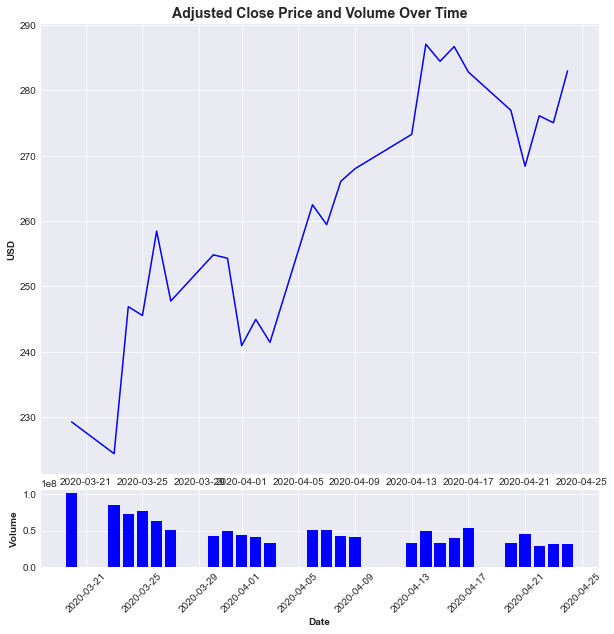

In [21]:
rcParams['figure.figsize'] = 10, 10
style.use('seaborn-darkgrid')

plt.figure()
ax1 = plt.subplot2grid((6,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan = 1, colspan = 1, sharex = ax1)

ax1.plot(AAPL_Stock['Date'], AAPL_Stock['Adj Close'], 'b-')
ax1.set_ylabel('USD', fontweight = 'bold')
ax1.set_title('Adjusted Close Price and Volume Over Time', fontsize = 14, fontweight = 'bold')
ax1.grid(True)

ax2.bar(AAPL_Stock['Date'], AAPL_Stock['Volume'], color = 'blue')
ax2.grid(True)
ax2.set_ylabel('Volume', fontweight = 'bold')

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [22]:
AAPL_Twitter['ORDER'] = [x for x in list(range(len(AAPL_Twitter)))]

merging_col = ['ORDER']

lag_col = ['COMPOUND']

In [23]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm(shift_range):
    train_shift = AAPL_Twitter[merging_col + lag_col].copy()
    
    train_shift['ORDER'] = train_shift['ORDER'] + shift
    
    col_name = lambda x: '{}_LAG_{}'.format(x, shift) if x in lag_col else x
    train_shift = train_shift.rename(columns = col_name)
    
    AAPL_Twitter = pd.merge(AAPL_Twitter, train_shift, on = merging_col, how = 'left')
    
del train_shift

AAPL_Twitter = AAPL_Twitter[N:]

AAPL_Twitter.head()

<ipython-input-23-28f22bc86c5c>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for shift in tqdm(shift_range):


,DATE,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE,NEG,NEU,POS,COMPOUND,RANGE_OC,RANGE_HL,ORDER,COMPOUND_LAG_1,COMPOUND_LAG_2,COMPOUND_LAG_3,COMPOUND_LAG_4,COMPOUND_LAG_5
5,2020-03-27,255.869995,247.050003,252.750000,247.740005,51054200,247.740005,0.025498,0.914735,0.059754,0.105195,5.009995,8.819992,5,0.065061,0.101594,0.101594,0.022388,0.022388
6,2020-03-30,255.520004,249.399994,250.740005,254.809998,41994100,254.809998,0.027110,0.923809,0.049088,0.076033,-4.069992,6.120010,6,0.105195,0.065061,0.101594,0.101594,0.022388
7,2020-03-31,262.489990,252.000000,255.600006,254.289993,49250500,254.289993,0.027110,0.923809,0.049088,0.076033,1.310013,10.489990,7,0.076033,0.105195,0.065061,0.101594,0.101594
8,2020-04-01,248.720001,239.130005,246.500000,240.910004,44054600,240.910004,0.036849,0.898863,0.064300,0.115092,5.589996,9.589996,8,0.076033,0.076033,0.105195,0.065061,0.101594
9,2020-04-02,245.149994,236.899994,240.339996,244.929993,41483500,244.929993,0.036849,0.898863,0.064300,0.115092,-4.589996,8.250000,9,0.115092,0.076033,0.076033,0.105195,0.065061


In [24]:
AAPL_Twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 5 to 24
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DATE            20 non-null     datetime64[ns]
 1   HIGH            20 non-null     float64       
 2   LOW             20 non-null     float64       
 3   OPEN            20 non-null     float64       
 4   CLOSE           20 non-null     float64       
 5   VOLUME          20 non-null     int64         
 6   ADJ_CLOSE       20 non-null     float64       
 7   NEG             20 non-null     float64       
 8   NEU             20 non-null     float64       
 9   POS             20 non-null     float64       
 10  COMPOUND        20 non-null     float64       
 11  RANGE_OC        20 non-null     float64       
 12  RANGE_HL        20 non-null     float64       
 13  ORDER           20 non-null     int64         
 14  COMPOUND_LAG_1  20 non-null     float64       
 15  COMPOUND

In [25]:
for col in lag_col:
    AAPL_Twitter = get_mov_avg_std(AAPL_Twitter, col)
    
AAPL_Twitter = get_mov_avg_std(AAPL_Twitter, 'ADJ_CLOSE')
AAPL_Twitter = get_mov_avg_std(AAPL_Twitter, 'RANGE_OC')
AAPL_Twitter = get_mov_avg_std(AAPL_Twitter, 'RANGE_HL')
    
AAPL_Twitter.head()

,DATE,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE,NEG,NEU,POS,...,COMPOUND_LAG_4,COMPOUND_LAG_5,COMPOUND_MEAN,COMPOUND_STD,ADJ_CLOSE_MEAN,ADJ_CLOSE_STD,RANGE_OC_MEAN,RANGE_OC_STD,RANGE_HL_MEAN,RANGE_HL_STD
5,2020-03-27,255.869995,247.050003,252.750000,247.740005,51054200,247.740005,0.025498,0.914735,0.059754,...,0.022388,0.022388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2020-03-30,255.520004,249.399994,250.740005,254.809998,41994100,254.809998,0.027110,0.923809,0.049088,...,0.101594,0.022388,0.105195,NaN,247.740005,NaN,5.009995,NaN,8.819992,NaN
7,2020-03-31,262.489990,252.000000,255.600006,254.289993,49250500,254.289993,0.027110,0.923809,0.049088,...,0.101594,0.101594,0.090614,0.020620,251.275002,4.999239,0.470001,6.420520,7.470001,1.909175
8,2020-04-01,248.720001,239.130005,246.500000,240.910004,44054600,240.910004,0.036849,0.898863,0.064300,...,0.065061,0.101594,0.085754,0.016836,252.279999,3.940337,0.750005,4.565824,8.476664,2.205127
9,2020-04-02,245.149994,236.899994,240.339996,244.929993,41483500,244.929993,0.036849,0.898863,0.064300,...,0.105195,0.065061,0.093088,0.020104,249.437500,6.532230,1.960003,4.444571,8.754997,1.884569


In [26]:
num_test = int(test_size * len(AAPL_Twitter))
num_train = len(AAPL_Twitter) - num_test
print('num_train:', str(num_train))
print('num_test:', str(num_test))
print('')

train = AAPL_Twitter[:num_train]
test = AAPL_Twitter[num_train:]
print('train.shape:', str(train.shape))
print('test.shape:', str(test.shape))

num_train: 15
num_test: 5

train.shape: (15, 27)
test.shape: (5, 27)


In [27]:
scaling_cols = ['ADJ_CLOSE', 'RANGE_OC', 'RANGE_HL']

for num in range(1, N+1):
    scaling_cols.append('COMPOUND_LAG_'+str(num))
    
scaler = StandardScaler()
train_scale = scaler.fit_transform(train[scaling_cols])
train_df_scaled = pd.DataFrame(train_scale, columns = scaling_cols)
train_df_scaled[['DATE']] = train.reset_index()[['DATE']]
train_df_scaled

,ADJ_CLOSE,RANGE_OC,RANGE_HL,COMPOUND_LAG_1,COMPOUND_LAG_2,COMPOUND_LAG_3,COMPOUND_LAG_4,COMPOUND_LAG_5,DATE
0,-0.998370,1.033545,0.123084,-0.970295,-0.243324,-0.214123,-1.533367,-1.485972,2020-03-27
1,-0.553826,-0.627052,-0.948957,-0.161586,-0.981394,-0.214123,-0.071595,-1.485972,2020-03-30
2,-0.586523,0.356872,0.786165,-0.749196,-0.170583,-0.951973,-0.071595,0.213702,2020-03-31
3,-1.427825,1.139619,0.428818,-0.749196,-0.759720,-0.141404,-0.745837,0.213702,2020-04-01
4,-1.175057,-0.722153,-0.103235,0.037836,-0.759720,-0.730366,-0.005145,-0.570272,2020-04-02
5,-1.396386,0.371501,-0.706760,0.037836,0.029357,-0.730366,-0.543334,0.290966,2020-04-03
6,-0.072183,-1.998695,2.072619,-0.481355,0.029357,0.058477,-0.543334,-0.334812,2020-04-06
7,-0.263332,2.196696,1.663665,-0.481355,-0.491183,0.058477,0.177505,-0.334812,2020-04-07
8,0.154177,-0.491721,-0.941027,-1.066161,-0.491183,-0.461908,0.177505,0.503342,2020-04-08
9,0.274901,0.247143,-1.246755,-0.162457,-1.077509,-0.461908,-0.298019,0.503342,2020-04-09


In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 20 to 24
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DATE            5 non-null      datetime64[ns]
 1   HIGH            5 non-null      float64       
 2   LOW             5 non-null      float64       
 3   OPEN            5 non-null      float64       
 4   CLOSE           5 non-null      float64       
 5   VOLUME          5 non-null      int64         
 6   ADJ_CLOSE       5 non-null      float64       
 7   NEG             5 non-null      float64       
 8   NEU             5 non-null      float64       
 9   POS             5 non-null      float64       
 10  COMPOUND        5 non-null      float64       
 11  RANGE_OC        5 non-null      float64       
 12  RANGE_HL        5 non-null      float64       
 13  ORDER           5 non-null      int64         
 14  COMPOUND_LAG_1  5 non-null      float64       
 15  COMPOUND

In [30]:
test_df_scaled = test[['DATE']]
for col in tqdm(lag_col):
    feat_list = [col + '_LAG_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_MEAN'], row[col+'_STD']), axis = 1)
    test_df_scaled = pd.concat([test_df_scaled, temp], axis = 1)
    
test_df_scaled['ADJ_CLOSE'] = test.apply(lambda row: scale_row(row['ADJ_CLOSE'], row['ADJ_CLOSE_MEAN'], row['ADJ_CLOSE_STD']), axis = 1)

test_df_scaled['RANGE_OC'] = test.apply(lambda row: scale_row(row['RANGE_OC'], row['RANGE_OC_MEAN'], row['RANGE_OC_STD']), axis = 1)

test_df_scaled['RANGE_HL'] = test.apply(lambda row: scale_row(row['RANGE_HL'], row['RANGE_HL_MEAN'], row['RANGE_HL_STD']), axis = 1)
        
    
test_df_scaled.head()

<ipython-input-30-075e875cb035>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm(lag_col):


,DATE,COMPOUND_LAG_1,COMPOUND_LAG_2,COMPOUND_LAG_3,COMPOUND_LAG_4,COMPOUND_LAG_5,ADJ_CLOSE,RANGE_OC,RANGE_HL
20,2020-04-20,-0.683909,-0.683909,-0.181881,-0.181881,1.731581,-1.049383,0.883312,-1.423373
21,2020-04-21,-1.475083,-0.196951,-0.196951,0.934492,0.934492,-3.709026,2.476335,1.728199
22,2020-04-22,-0.976068,-0.976068,0.280058,0.280058,1.392020,-0.508573,-1.195904,-0.632464
23,2020-04-23,1.051030,-1.071950,-1.071950,0.546435,0.546435,-0.449841,-0.254072,-0.251302
24,2020-04-24,0.871410,0.871410,-1.075715,-1.075715,0.408612,1.382885,-2.009615,-0.622671


In [61]:
features = []

for i in range(1, N+1):
    features.append('COMPOUND_LAG_'+str(i))
    
target = 'ADJ_CLOSE'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

print('X_train.shape:', str(X_train.shape))
print('y_train.shape:', str(y_train.shape))
print('X_test.shape:', str(X_test.shape))
print('y_test.shape:', str(y_test.shape))

X_train.shape: (15, 5)
y_train.shape: (15,)
X_test.shape: (5, 5)
y_test.shape: (5,)


In [62]:
X_train_scaled = train_df_scaled[features]
y_train_scaled = train_df_scaled[target]
X_test_scaled = test_df_scaled[features]

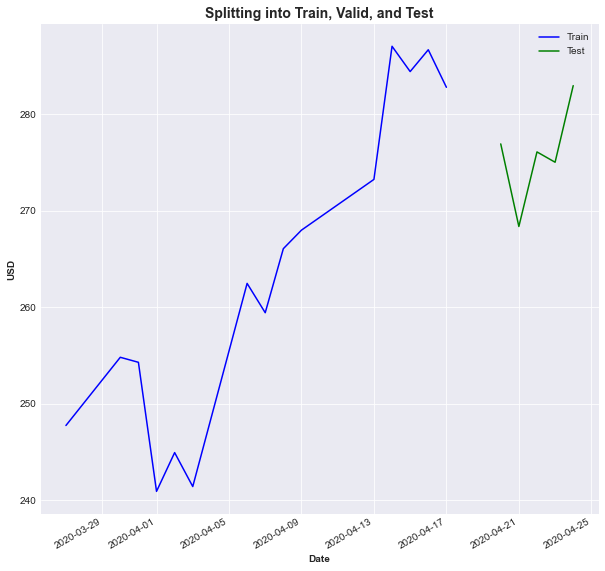

In [63]:
rcParams['figure.figsize'] = 10, 10

ax = train.plot(x='DATE', y='ADJ_CLOSE', style='b-', grid=True)
ax = test.plot(x='DATE', y='ADJ_CLOSE', style='g-', grid=True, ax=ax)
ax.legend(['Train', 'Test'])
ax.set_xlabel("Date", fontweight = 'bold')
ax.set_ylabel("USD", fontweight = 'bold')
ax.set_title("Splitting into Train, Valid, and Test", fontsize = 14, fontweight = 'bold');

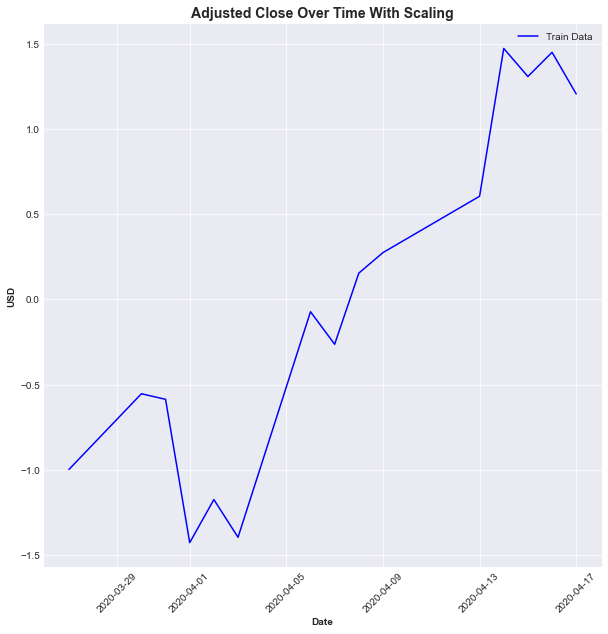

In [64]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train_df_scaled['DATE'], train_df_scaled['ADJ_CLOSE'], 'b-')
plt.legend(['Train Data'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Over Time With Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [65]:
reg_model = LinearRegression(fit_intercept = True)

reg_model.fit(X_train_scaled, y_train_scaled)
est_train_scaled = reg_model.predict(X_train_scaled)
est_train = est_train_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

est_train_df = pd.DataFrame({'DATE':train['DATE'],
                                'PREDICTION': est_train})

print('R-Square Score:', r2_score(y_train, est_train))
print('Mean Square Score:', mean_squared_error(y_train, est_train))

R-Square Score: 0.7698329352736655
Mean Square Score: 58.21716158927257


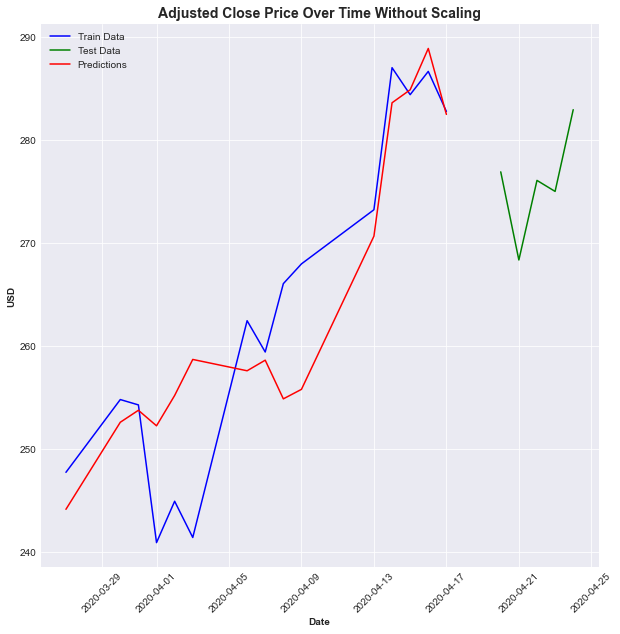

In [66]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(est_train_df['DATE'], est_train_df['PREDICTION'], 'r-')
plt.legend(['Train Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [67]:
est_test_scaled = reg_model.predict(X_test_scaled)
test['PREDICT_VALID'] = est_test_scaled
test['PREDICT'] = test['PREDICT_VALID'] * test['ADJ_CLOSE_STD'] + test['ADJ_CLOSE_MEAN']

est_test_df = pd.DataFrame({'DATE':test['DATE'],
                           'PREDICTION':test['PREDICT']})

print('R-Square Score:', r2_score(y_test, test['PREDICT']))
print('Mean Square Score:', mean_squared_error(y_test, test['PREDICT']))

R-Square Score: -1.6612503774122542
Mean Square Score: 57.77131738864391


<ipython-input-67-a813c88038a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['PREDICT_VALID'] = est_test_scaled
<ipython-input-67-a813c88038a1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['PREDICT'] = test['PREDICT_VALID'] * test['ADJ_CLOSE_STD'] + test['ADJ_CLOSE_MEAN']


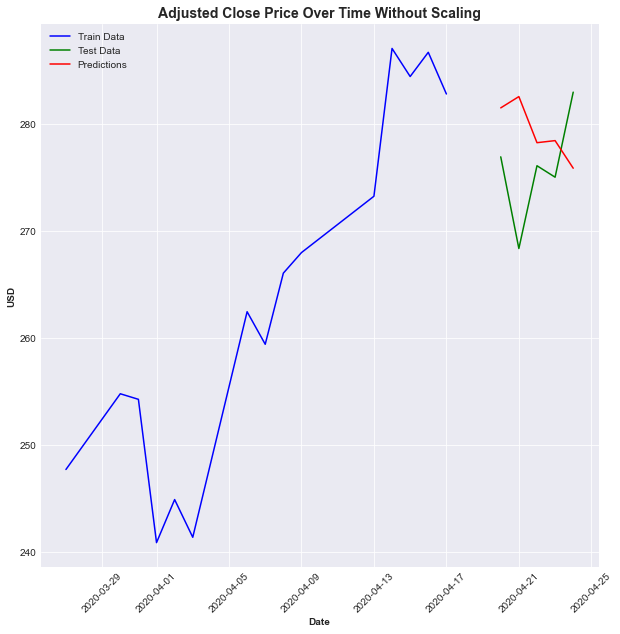

In [68]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(est_test_df['DATE'], est_test_df['PREDICTION'], 'r-')
plt.legend(['Train Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [69]:
features = []

for i in range(1, N+1):
    features.append('COMPOUND_LAG_'+str(i))
    
target_2 = 'RANGE_OC'

X_train = train[features]
y_train = train[target_2]
X_test = test[features]
y_test = test[target_2]

print('X_train.shape:', str(X_train.shape))
print('y_train.shape:', str(y_train.shape))
print('X_test.shape:', str(X_test.shape))
print('y_test.shape:', str(y_test.shape))

X_train.shape: (15, 5)
y_train.shape: (15,)
X_test.shape: (5, 5)
y_test.shape: (5,)


In [70]:
X_train_scaled = train_df_scaled[features]
y_train_scaled = train_df_scaled[target_2]
X_test_scaled = test_df_scaled[features]

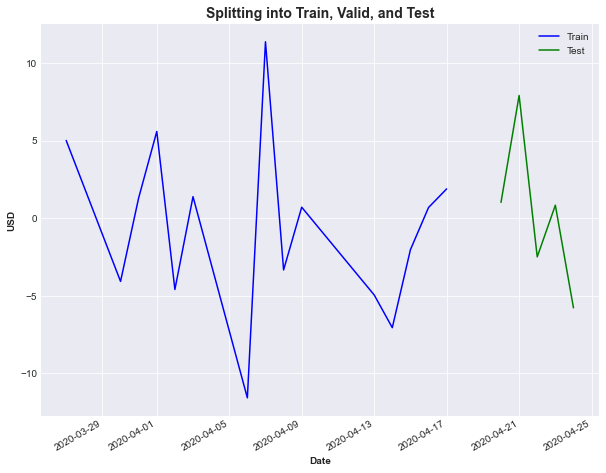

In [71]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='DATE', y='RANGE_OC', style='b-', grid=True)
ax = test.plot(x='DATE', y='RANGE_OC', style='g-', grid=True, ax=ax)
ax.legend(['Train', 'Test'])
ax.set_xlabel("Date", fontweight = 'bold')
ax.set_ylabel("USD", fontweight = 'bold')
ax.set_title("Splitting into Train, Valid, and Test", fontsize = 14, fontweight = 'bold');

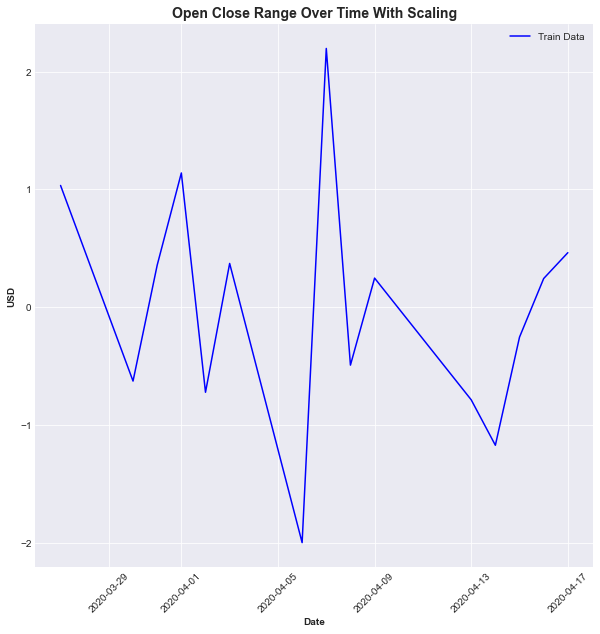

In [72]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train_df_scaled['DATE'], train_df_scaled['RANGE_OC'], 'b-')
plt.legend(['Train Data'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('Open Close Range Over Time With Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [73]:
reg_model = LinearRegression(fit_intercept = True)

reg_model.fit(X_train_scaled, y_train_scaled)
est_train_scaled = reg_model.predict(X_train_scaled)
est_train = est_train_scaled * math.sqrt(scaler.var_[1]) + scaler.mean_[1]

est_train_df = pd.DataFrame({'DATE':train['DATE'],
                                'PREDICTION': est_train})

print('R-Square Score:', r2_score(y_train, est_train))
print('Mean Square Score:', mean_squared_error(y_train, est_train))

R-Square Score: 0.23737469563924352
Mean Square Score: 22.80095943705739


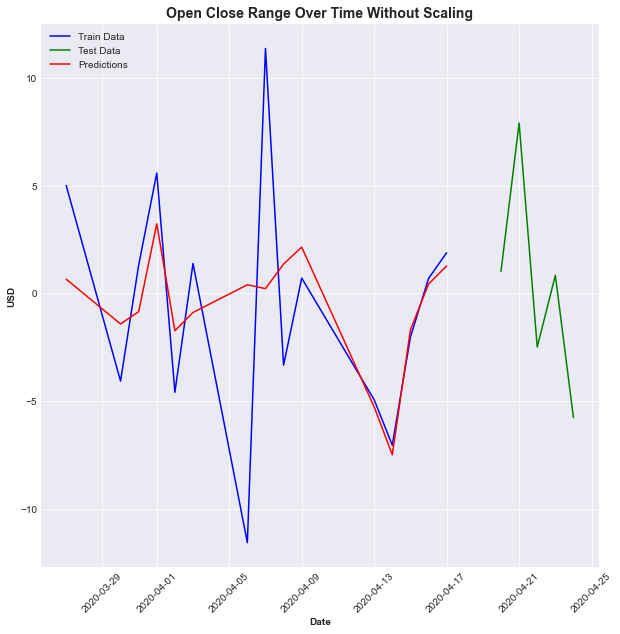

In [75]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['RANGE_OC'], 'b-')
plt.plot(test['DATE'], test['RANGE_OC'], 'g-')
plt.plot(est_train_df['DATE'], est_train_df['PREDICTION'], 'r-')
plt.legend(['Train Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('Open Close Range Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [76]:
est_test_scaled = reg_model.predict(X_test_scaled)
test['PREDICT_VALID'] = est_test_scaled
test['PREDICT'] = test['PREDICT_VALID'] * test['RANGE_OC_STD'] + test['RANGE_OC_MEAN']

est_test_df = pd.DataFrame({'DATE':test['DATE'],
                           'PREDICTION':test['PREDICT']})

print('R-Square Score:', r2_score(y_test, test['PREDICT']))
print('Mean Square Score:', mean_squared_error(y_test, test['PREDICT']))

R-Square Score: -0.5594335977475036
Mean Square Score: 32.23384873082746


<ipython-input-76-9c72ceb961a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['PREDICT_VALID'] = est_test_scaled
<ipython-input-76-9c72ceb961a7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['PREDICT'] = test['PREDICT_VALID'] * test['RANGE_OC_STD'] + test['RANGE_OC_MEAN']


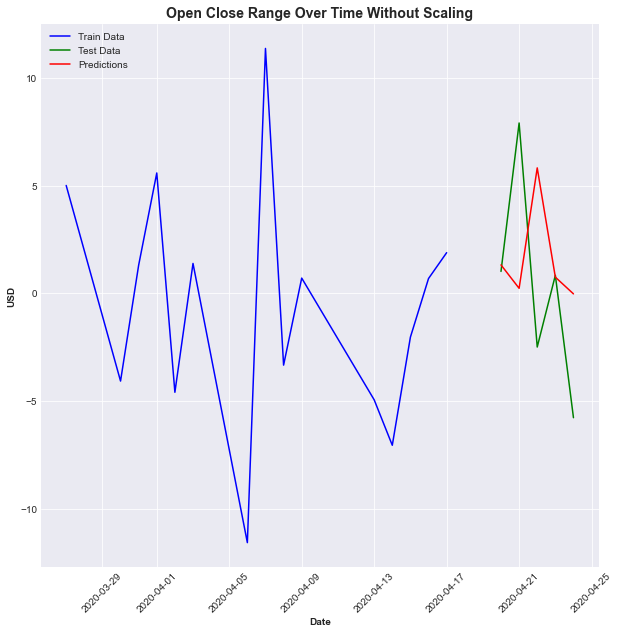

In [77]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['RANGE_OC'], 'b-')
plt.plot(test['DATE'], test['RANGE_OC'], 'g-')
plt.plot(est_test_df['DATE'], est_test_df['PREDICTION'], 'r-')
plt.legend(['Train Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('Open Close Range Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [78]:
features = []

for i in range(1, N+1):
    features.append('COMPOUND_LAG_'+str(i))
    
target_3 = 'RANGE_HL'

X_train = train[features]
y_train = train[target_3]
X_test = test[features]
y_test = test[target_3]

print('X_train.shape:', str(X_train.shape))
print('y_train.shape:', str(y_train.shape))
print('X_test.shape:', str(X_test.shape))
print('y_test.shape:', str(y_test.shape))

X_train.shape: (15, 5)
y_train.shape: (15,)
X_test.shape: (5, 5)
y_test.shape: (5,)


In [79]:
X_train_scaled = train_df_scaled[features]
y_train_scaled = train_df_scaled[target_3]
X_test_scaled = test_df_scaled[features]

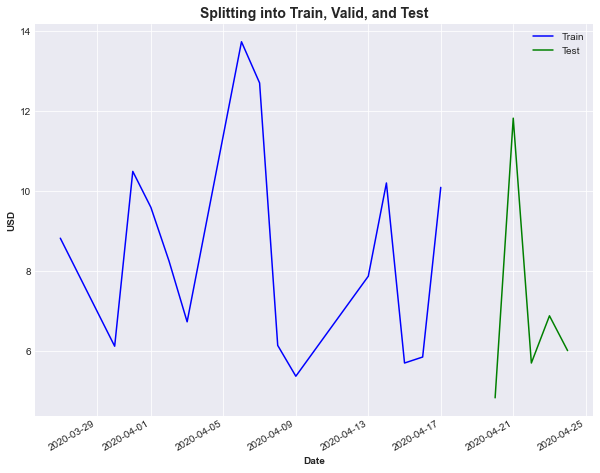

In [80]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='DATE', y='RANGE_HL', style='b-', grid=True)
ax = test.plot(x='DATE', y='RANGE_HL', style='g-', grid=True, ax=ax)
ax.legend(['Train', 'Test'])
ax.set_xlabel("Date", fontweight = 'bold')
ax.set_ylabel("USD", fontweight = 'bold')
ax.set_title("Splitting into Train, Valid, and Test", fontsize = 14, fontweight = 'bold');

In [81]:
reg_model = LinearRegression(fit_intercept = True)

reg_model.fit(X_train_scaled, y_train_scaled)
est_train_scaled = reg_model.predict(X_train_scaled)
est_train = est_train_scaled * math.sqrt(scaler.var_[2]) + scaler.mean_[2]

est_train_df = pd.DataFrame({'DATE':train['DATE'],
                                'PREDICTION': est_train})

print('R-Square Score:', r2_score(y_train, est_train))
print('Mean Square Score:', mean_squared_error(y_train, est_train))

R-Square Score: 0.15911565665059924
Mean Square Score: 5.333778841259055


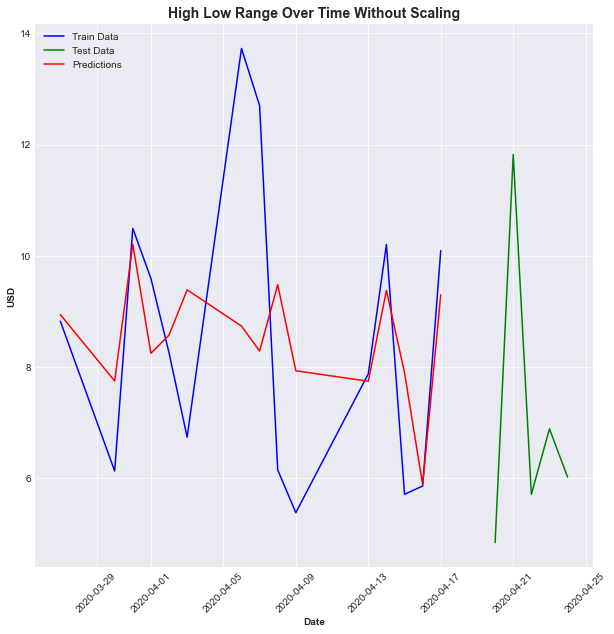

In [82]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['RANGE_HL'], 'b-')
plt.plot(test['DATE'], test['RANGE_HL'], 'g-')
plt.plot(est_train_df['DATE'], est_train_df['PREDICTION'], 'r-')
plt.legend(['Train Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('High Low Range Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [83]:
est_test_scaled = reg_model.predict(X_test_scaled)
test['PREDICT_VALID'] = est_test_scaled
test['PREDICT'] = test['PREDICT_VALID'] * test['RANGE_HL_STD'] + test['RANGE_HL_MEAN']

est_test_df = pd.DataFrame({'DATE':test['DATE'],
                           'PREDICTION':test['PREDICT']})

print('R-Square Score:', r2_score(y_test, test['PREDICT']))
print('Mean Square Score:', mean_squared_error(y_test, test['PREDICT']))

R-Square Score: -0.08150367087973076
Mean Square Score: 6.621925182095756


<ipython-input-83-75a5fc6cc33b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['PREDICT_VALID'] = est_test_scaled
<ipython-input-83-75a5fc6cc33b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['PREDICT'] = test['PREDICT_VALID'] * test['RANGE_HL_STD'] + test['RANGE_HL_MEAN']


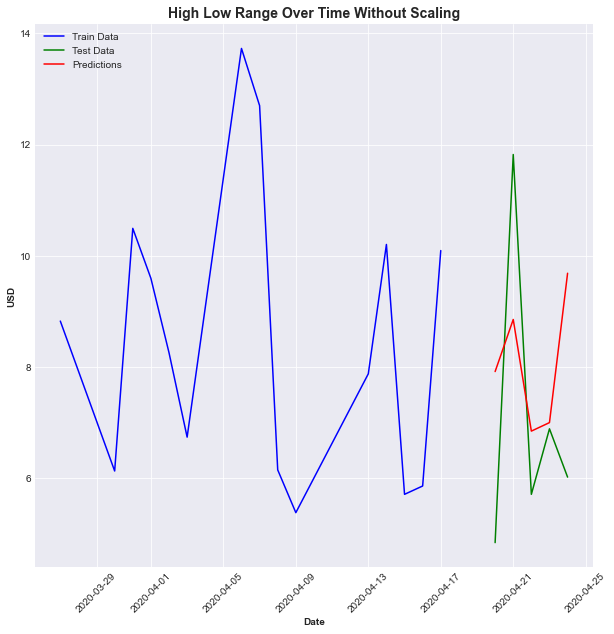

In [84]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['RANGE_HL'], 'b-')
plt.plot(test['DATE'], test['RANGE_HL'], 'g-')
plt.plot(est_test_df['DATE'], est_test_df['PREDICTION'], 'r-')
plt.legend(['Train Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('High Low Range Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()